# Edge-driven convection - heat transport and velocity scalings

This notebook uses aspect to compute the heat transport and velocity scalings for three modes of convection.
1. Standard Rayleigh-Benard convection
2. Edge driven convection with insulating bottom and right boundaries, hot left boundary, cold lid
3. Hybrid convection with hot left and bottom, insulating right, cold lid.

There are three .prm files corresponding to the different heating modes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subprocess import run

input_file_base = "input"                  # The temporary input file that is used for each run
aspect_bin = "./aspect-release"            # Path to aspect executable

In [2]:
# Create a dictionary to replace keys in base input file with appropriate values
parameters = dict([])
parameters['RAYLEIGH'] = 0.0          # vertical gravitational acceleration

def generate_input_file(base_file_name,output_file_name,dictionary):
    """Read the 'base' input file from base_file_name, replace strings 
    using dictionary, and write new output file to output_file_name"""
    fh = open(base_file_name,'r')
    run(['rm','-f',output_file_name])
    ofh = open(output_file_name,'w')
    for line in fh:        
        for key in dictionary:
            if key in line:                
                line = line.replace(key,str(dictionary[key]))
        ofh.write(line)
    fh.close()
    ofh.close()
    
def parse_output(output_dir):
    """Read the statistics (stats_file) file from the output directory"""
    tmp = np.loadtxt(output_dir + '/statistics',usecols=(1, 11,19))
    t=tmp[:,0]
    vmax = tmp[:,1]
    qsurf = tmp[:,2]
    return t,vmax,qsurf
    
def vy_exact(t,p):
    """Evaluate exact expression for maximum upward velocity"""
    lam = p['WIDTH']
    b = p['HEIGHT']
    g = p['GRAVITY']
    T0 = p['PMAG']
    alpha = p['ALPHA']
    eta = p['VISCOSITY']
    rho = p['DENSITY']
    dT = p['DELTA_T']
    kappa = p['KTHERMAL']/rho/p['SPECIFIC_HEAT']
    alpha_prime = kappa/b**2*((rho*g*alpha*b**3*dT/eta/kappa)*(4.0*np.pi**2*b**2/lam**2/(4.0*np.pi**2*b**2/lam**2+np.pi**2)**2)-(np.pi**2+4.0*np.pi**2*b**2/lam**2))
    phi0 = -2.0*np.pi/lam*(rho*g*alpha*T0/eta)*(4.*np.pi**2/lam**2 + np.pi**2/b**2)**(-2.0)
    vymax = 2.0*np.pi/lam*phi0 * np.exp(alpha_prime*t)
    return vymax

def plot_single_run(ra,t,vmax,qsurf):
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t,vmax);
    plt.title("Ra={:.2e}".format(ra))

    plt.subplot(2,1,2)
    plt.plot(t,qsurf);
    
def run_aspect(rayleigh,base_input_file,p=parameters):
    """Perofm the following tasks. 
    1. Choose viscosity to satisfy rayleigh number rayleigh and parameters in p, which
    defaults to the parameters dictionary defined in the current namespace. 
    2. Generate an input file. 
    3. Run aspect
    4. Parse the results, return the rate at which velocities increase between the first and second timesteps."""
           
    
    p['RAYLEIGH'] = rayleigh; # rayleigh should be a string...
    input_file = base_input_file[:-5] + rayleigh + ".prm" # note that we expect a string
    output_dir = "output-" + base_input_file[:-5] + "-" + rayleigh # remove -base from end of input file.
    generate_input_file(base_input + ".prm",input_file,p)
    run(['rm','-rf',output_dir])
    run([aspect_bin,input_file],capture_output=True)
    t, vmax, qsurf = parse_output(output_dir)
    return t,vmax,qsurf



In [3]:
base_input = "edge-isoviscous-base"    # The 'base' input file that gets modified
rayleigh_numbers = 10.0 ** np.linspace(0,5,11) # 11 for full run
print(rayleigh_numbers)
t_edge = []
vmax_edge = []
qsurf_edge = []
for ra in rayleigh_numbers:
    ras = "{:.3e}".format(ra)
    print("Now on ra="+ras)
    t1,vmax1,qsurf1 = run_aspect(ras,base_input,parameters)
    t_edge.append(t1)
    vmax_edge.append(vmax1)
    qsurf_edge.append(qsurf1)

[1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04 3.16227766e+04 1.00000000e+05]
Now on ra=1.000e+00
Now on ra=3.162e+00
Now on ra=1.000e+01
Now on ra=3.162e+01
Now on ra=1.000e+02
Now on ra=3.162e+02
Now on ra=1.000e+03
Now on ra=3.162e+03
Now on ra=1.000e+04
Now on ra=3.162e+04
Now on ra=1.000e+05


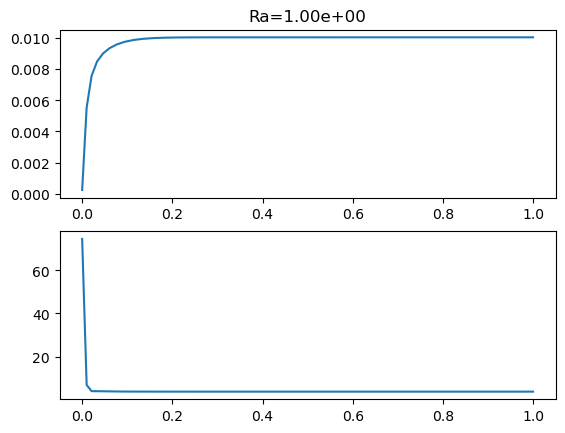

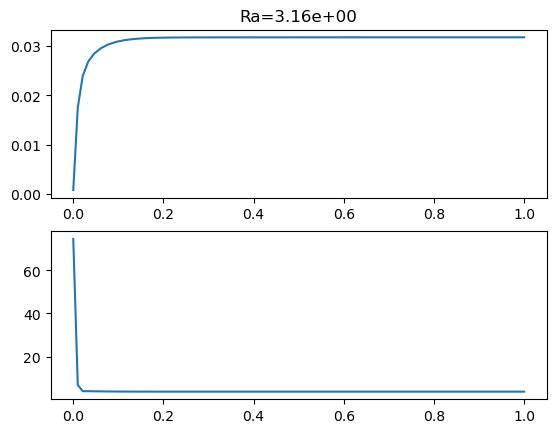

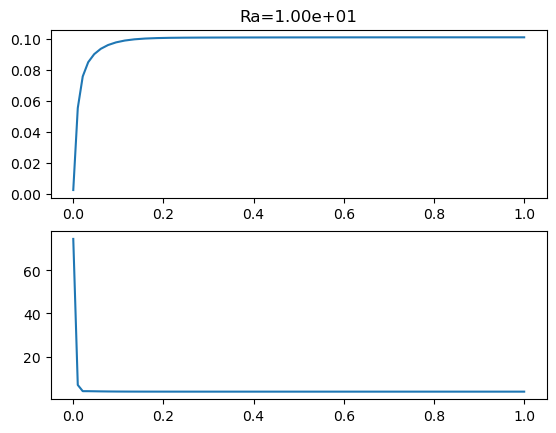

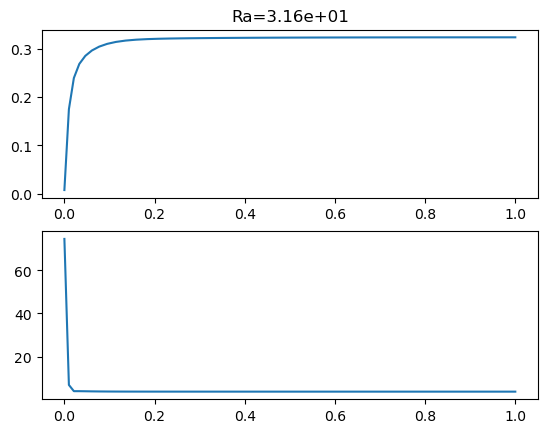

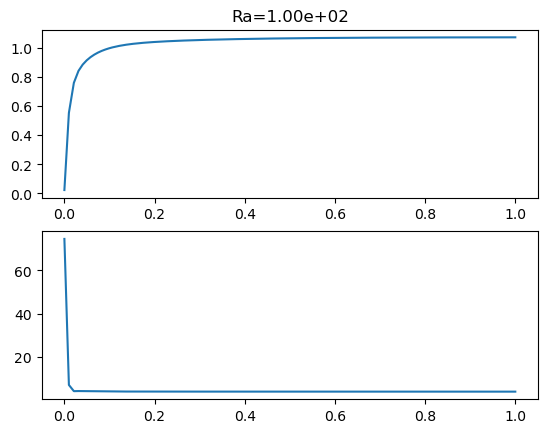

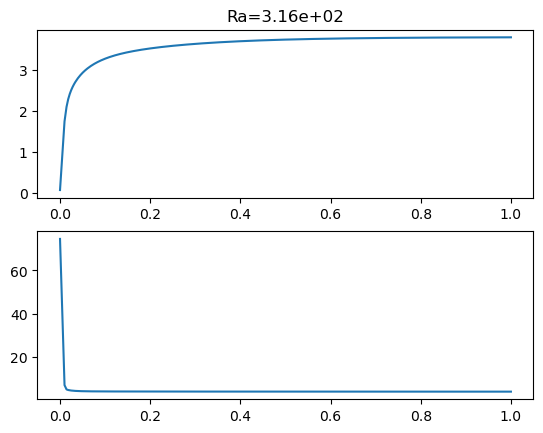

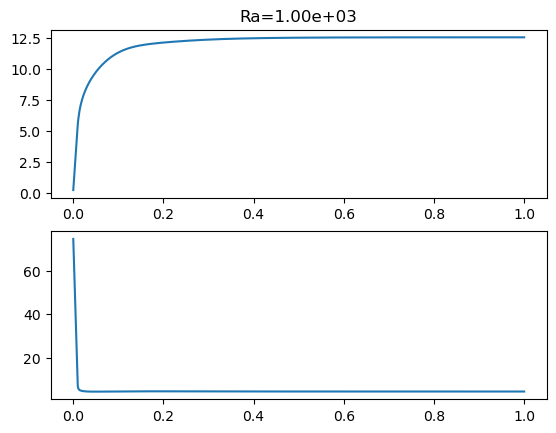

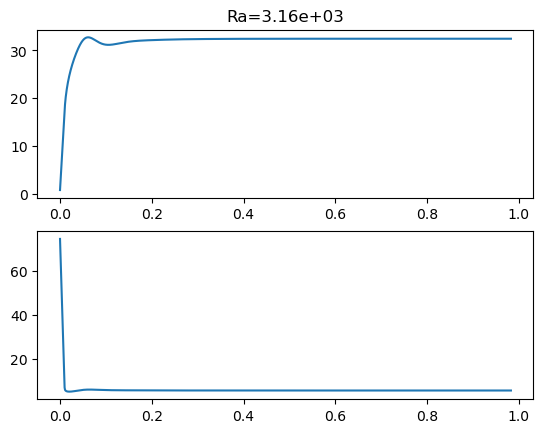

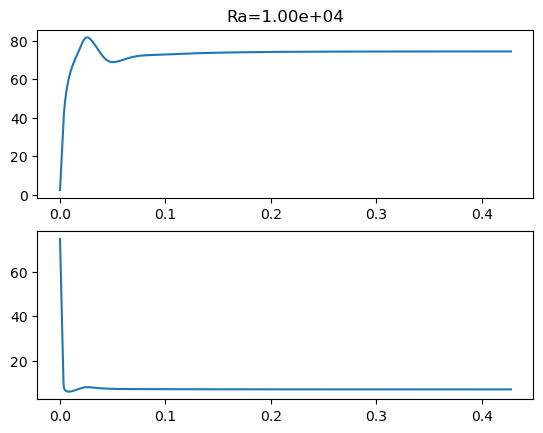

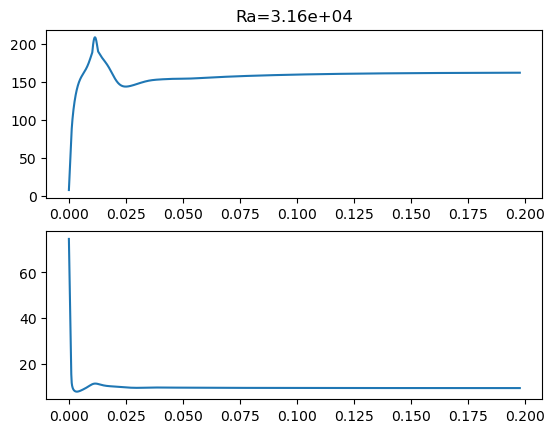

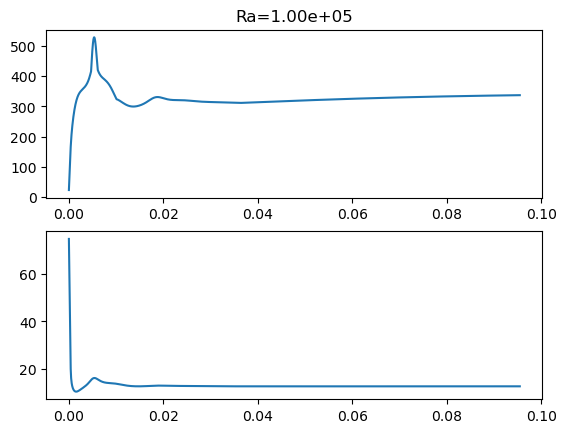

In [4]:
for i in range(len(rayleigh_numbers)):
    plot_single_run(rayleigh_numbers[i],t_edge[i],vmax_edge[i],qsurf_edge[i])

Text(0.5, 0, 'Ra')

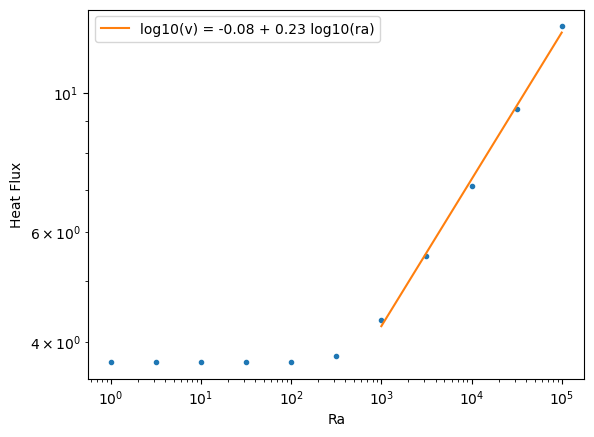

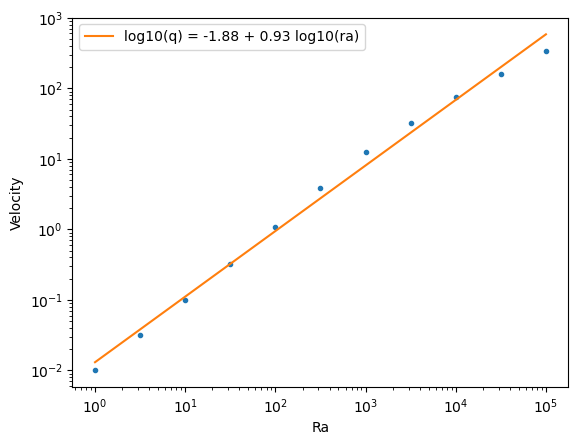

In [5]:
# Making a scaling plot:
qdata_edge = []
vdata_edge = []
for q in qsurf_edge:
    qdata_edge.append(q[-1])
for v in vmax_edge:
    vdata_edge.append(v[-1])
plt.figure()
plt.plot(rayleigh_numbers,qdata_edge,'.')
start=6
b,a = np.polyfit(np.log10(rayleigh_numbers[start:]),np.log10(qdata_edge[start:]),1)
plt.plot(rayleigh_numbers[start:],10**(a + b*np.log10(rayleigh_numbers[start:])),label="log10(v) = {:.2f} + {:.2f} log10(ra)".format(a,b))
plt.legend()

ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Heat Flux")
ax.set_xlabel("Ra")

plt.figure()
plt.plot(rayleigh_numbers,vdata_edge,'.')

b,a = np.polyfit(np.log10(rayleigh_numbers),np.log10(vdata_edge),1)
plt.plot(rayleigh_numbers,10**(a + b*np.log10(rayleigh_numbers)),label="log10(q) = {:.2f} + {:.2f} log10(ra)".format(a,b))
plt.legend()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Velocity")
ax.set_xlabel("Ra")



# Run the basal-heating cases:

In [6]:
base_input = "basal-isoviscous-base"    # The 'base' input file that gets modified
# rayleigh_numbers = 10.0 ** np.linspace(0,5,11) # 11 for full run
print(rayleigh_numbers)
ra_basal = []
t_basal = []
vmax_basal = []
qsurf_basal = []
for ra in rayleigh_numbers:
    if ra>651.5:        # only run cases above min. critical Ra
        ras = "{:.3e}".format(ra)
        print("Now on ra="+ras)
        t1,vmax1,qsurf1 = run_aspect(ras,base_input,parameters)
        ra_basal.append(ra)
        t_basal.append(t1)
        vmax_basal.append(vmax1)
        qsurf_basal.append(qsurf1)

[1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04 3.16227766e+04 1.00000000e+05]
Now on ra=1.000e+03
Now on ra=3.162e+03
Now on ra=1.000e+04
Now on ra=3.162e+04
Now on ra=1.000e+05


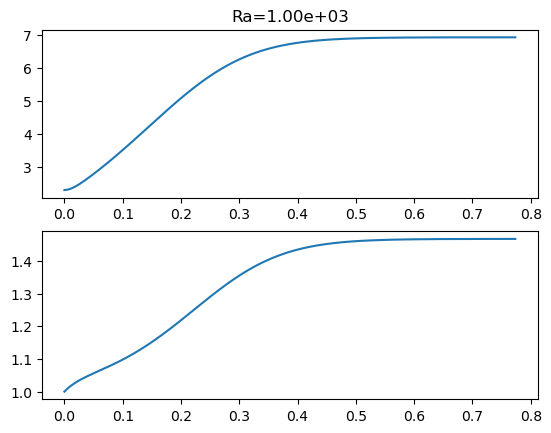

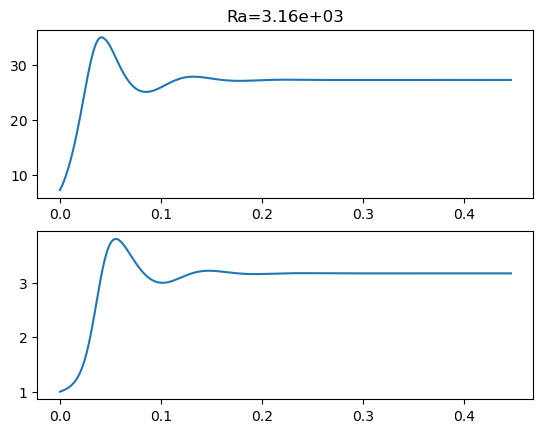

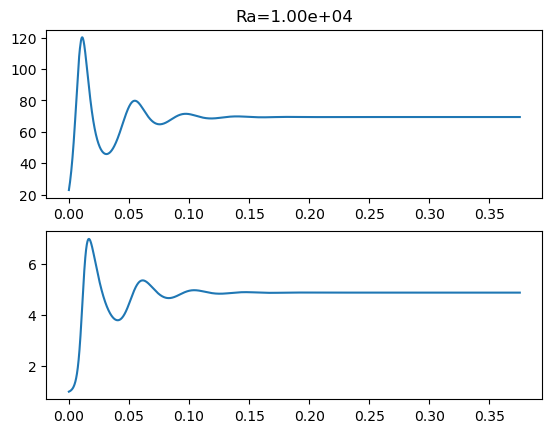

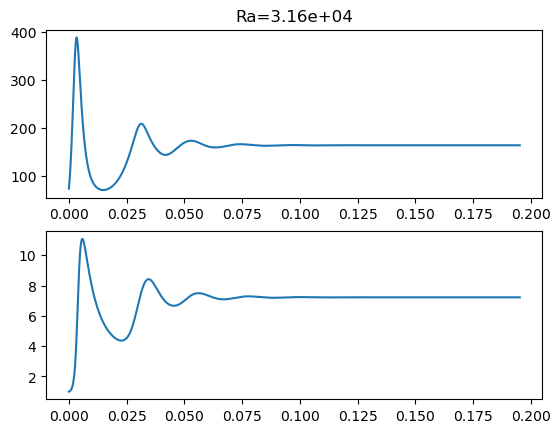

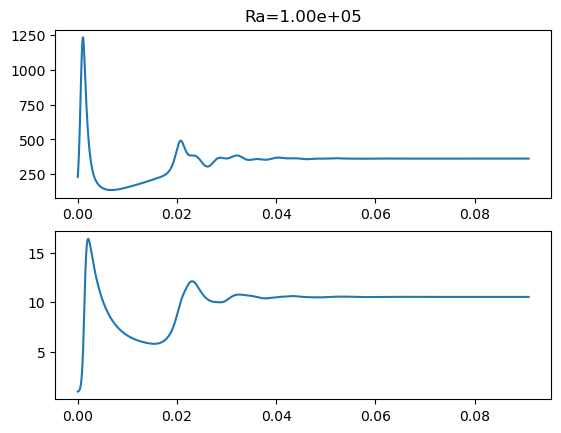

In [7]:
for i in range(len(ra_basal)):
    plot_single_run(ra_basal[i],t_basal[i],vmax_basal[i],qsurf_basal[i])

Text(0.5, 0, 'Ra')

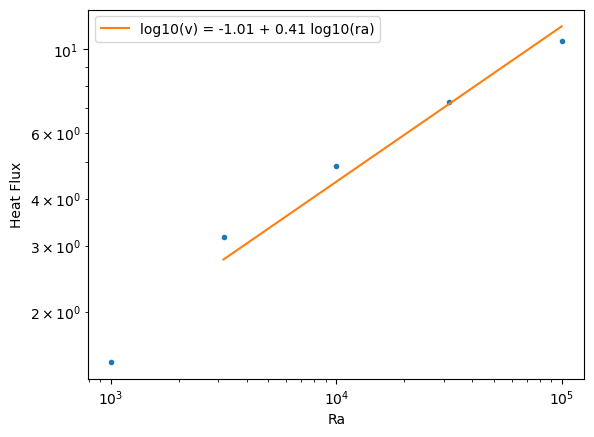

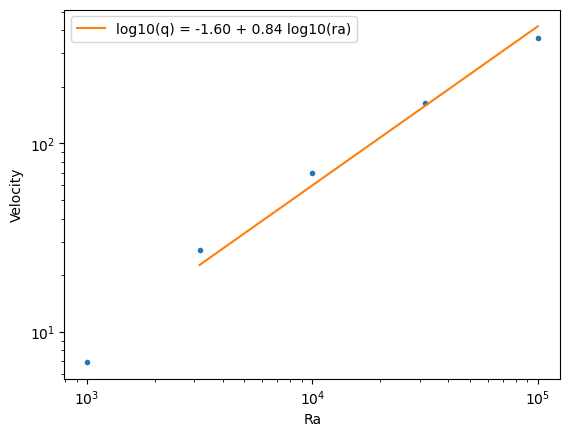

In [11]:
# Making a scaling plot:
qdata_basal = []
vdata_basal = []
for q in qsurf_basal:
    qdata_basal.append(q[-1])
for v in vmax_basal:
    vdata_basal.append(v[-1])
plt.figure()
plt.plot(ra_basal,qdata_basal,'.')
start=7
b,a = np.polyfit(np.log10(ra_basal),np.log10(qdata_basal),1)
plt.plot(rayleigh_numbers[start:],10**(a + b*np.log10(rayleigh_numbers[start:])),label="log10(v) = {:.2f} + {:.2f} log10(ra)".format(a,b))
plt.legend()

ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Heat Flux")
ax.set_xlabel("Ra")

plt.figure()
plt.plot(ra_basal,vdata_basal,'.')

b,a = np.polyfit(np.log10(ra_basal),np.log10(vdata_basal),1)
plt.plot(rayleigh_numbers[start:],10**(a + b*np.log10(rayleigh_numbers[start:])),label="log10(q) = {:.2f} + {:.2f} log10(ra)".format(a,b))
plt.legend()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Velocity")
ax.set_xlabel("Ra")


# Run the hybrid cases - lower boundary has T=1 rather than insulating.

In [12]:
base_input = "hybrid-isoviscous-base"
print(rayleigh_numbers)
t_hybrid = []
vmax_hybrid = []
qsurf_hybrid = []
for ra in rayleigh_numbers:    
    ras = "{:.3e}".format(ra)
    print("Now on ra="+ras)
    t1,vmax1,qsurf1 = run_aspect(ras,base_input,parameters)
    t_hybrid.append(t1)
    vmax_hybrid.append(vmax1)
    qsurf_hybrid.append(qsurf1)

[1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04 3.16227766e+04 1.00000000e+05]
Now on ra=1.000e+00
Now on ra=3.162e+00
Now on ra=3.162e+03
Now on ra=1.000e+04
Now on ra=3.162e+04
Now on ra=1.000e+05


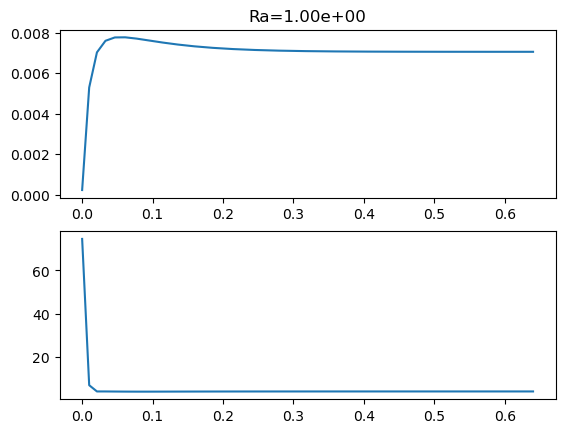

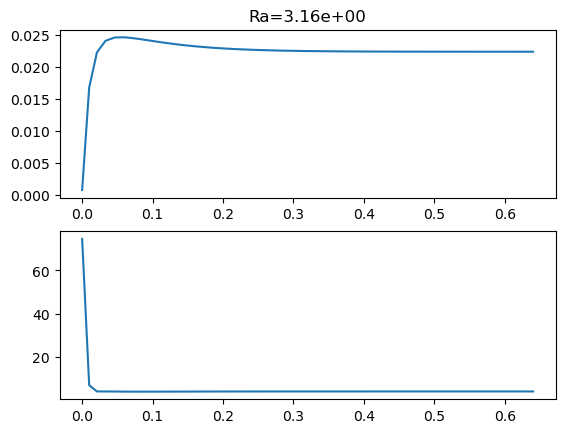

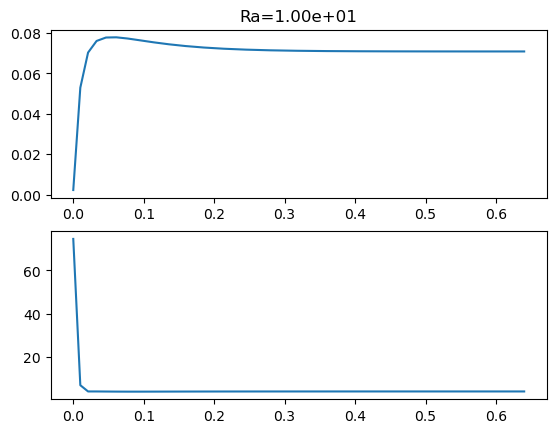

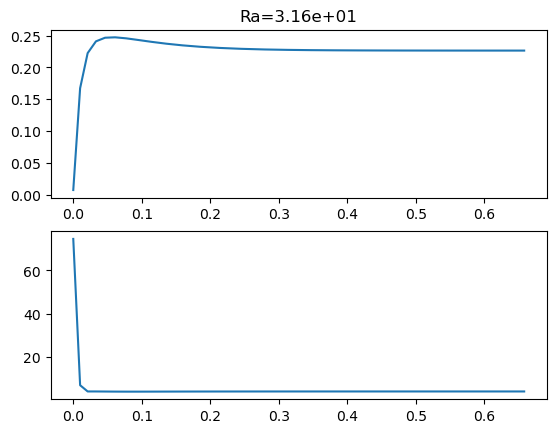

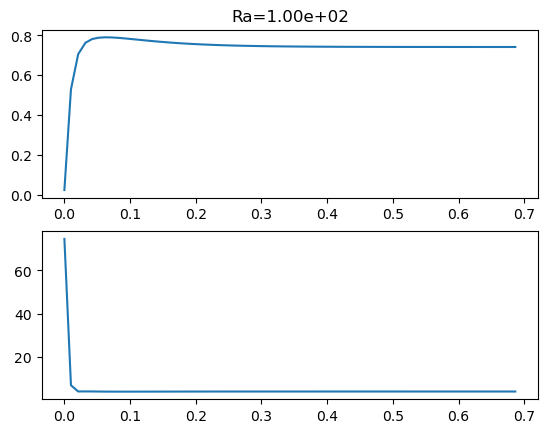

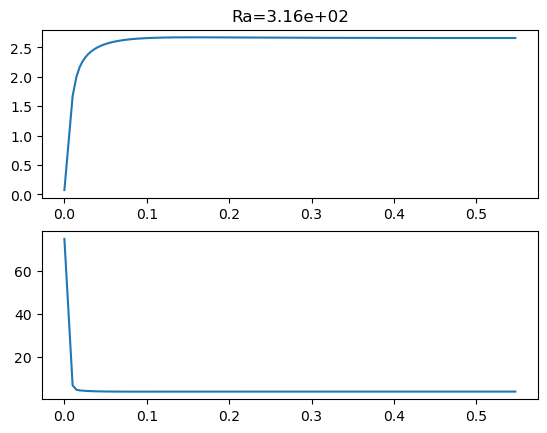

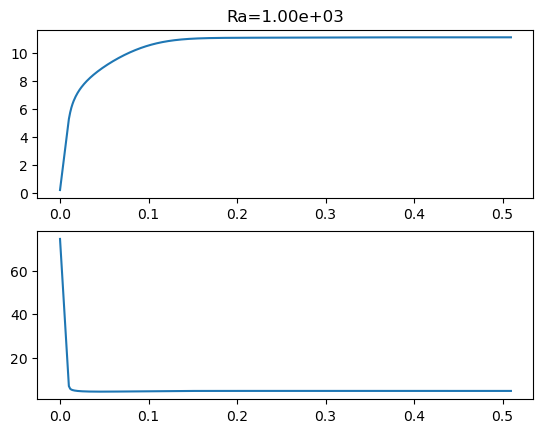

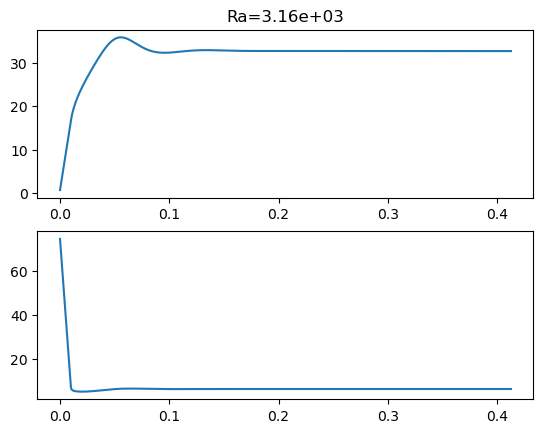

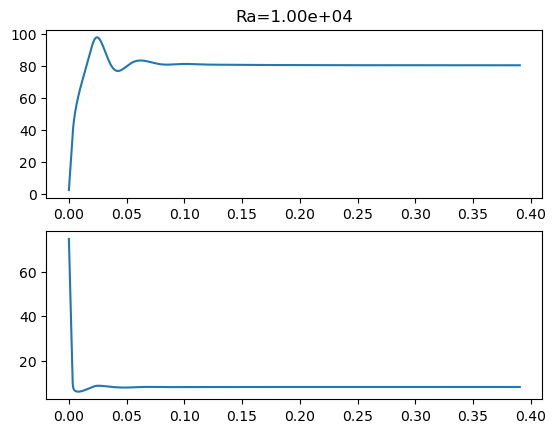

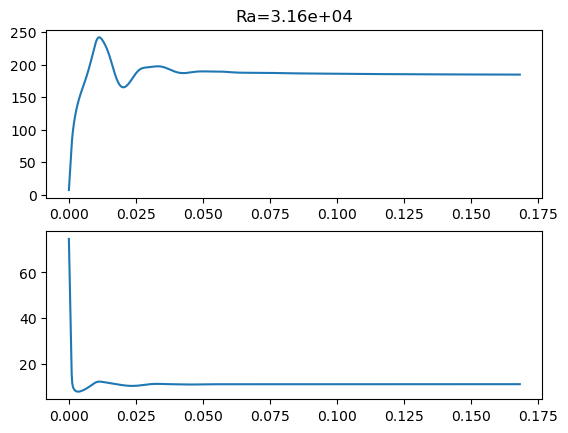

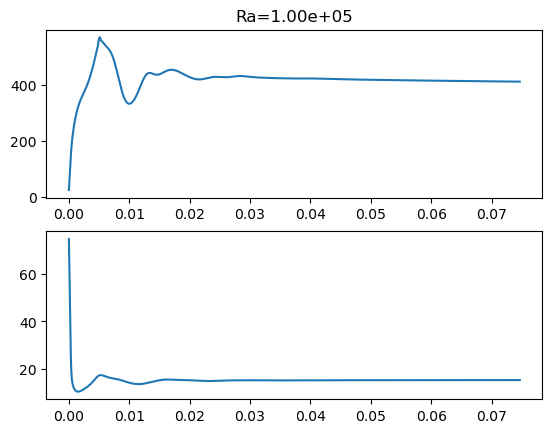

In [13]:
for i in range(len(rayleigh_numbers)):
    plot_single_run(rayleigh_numbers[i],t_hybrid[i],vmax_hybrid[i],qsurf_hybrid[i])

Text(0.5, 0, 'Ra')

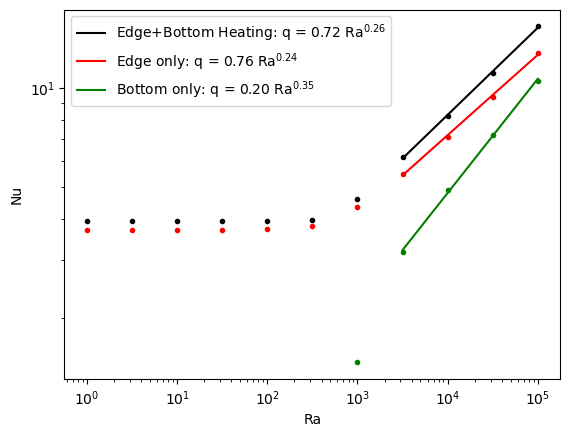

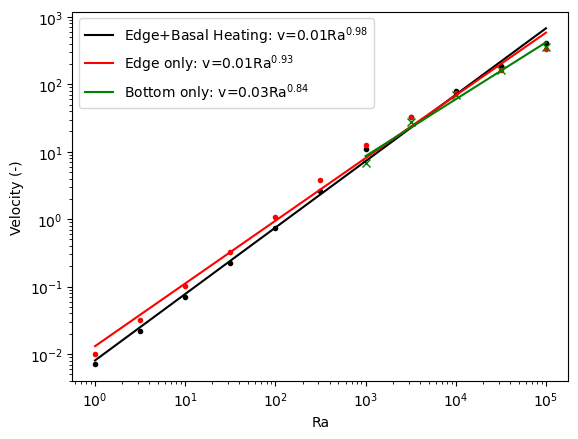

In [22]:
# Making a scaling plot:
qdata_hybrid = []
vdata_hybrid = []
for q in qsurf_hybrid:
    qdata_hybrid.append(q[-1])
for v in vmax_hybrid:
    vdata_hybrid.append(v[-1])
plt.figure()
plt.plot(rayleigh_numbers,qdata_hybrid,'k.')
plt.plot(rayleigh_numbers,qdata_edge,'r.')
plt.plot(ra_basal,qdata_basal,'g.')
start=7
# hybrid:
b,a = np.polyfit(np.log10(rayleigh_numbers[start:]),np.log10(qdata_hybrid[start:]),1)
a1 = 10**a
plt.plot(rayleigh_numbers[start:],a1*rayleigh_numbers[start:]**b,'k',label="Edge+Bottom Heating: q = {:.2f} Ra$^{{{:.2f}}}$".format(a1,b))
# edge-driven:
b,a = np.polyfit(np.log10(rayleigh_numbers[start:]),np.log10(qdata_edge[start:]),1)
a1 = 10**a
plt.plot(rayleigh_numbers[start:],a1*rayleigh_numbers[start:]**b,'r',label="Edge only: q = {:.2f} Ra$^{{{:.2f}}}$".format(a1,b))
# basal:
start=1
b,a = np.polyfit(np.log10(ra_basal[start:]),np.log10(qdata_basal[start:]),1)
a1 = 10**a
plt.plot(ra_basal[start:],a1*ra_basal[start:]**b,'g',label="Bottom only: q = {:.2f} Ra$^{{{:.2f}}}$".format(a1,b))

plt.legend()

ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Nu")
ax.set_xlabel("Ra")

plt.figure()
plt.plot(rayleigh_numbers,vdata_hybrid,'k.')
plt.plot(rayleigh_numbers,vdata_edge,'r.')
plt.plot(ra_basal,vdata_basal,'gx')
start=0
b,a = np.polyfit(np.log10(rayleigh_numbers[start:]),np.log10(vdata_hybrid[start:]),1)
a1 = 10**a
plt.plot(rayleigh_numbers[start:],a1*rayleigh_numbers[start:]**b,'k',label="Edge+Basal Heating: v={:.2f}Ra$^{{{:.2f}}}$".format(a1,b))

b,a = np.polyfit(np.log10(rayleigh_numbers[start:]),np.log10(vdata_edge[start:]),1)
a1 = 10**a
plt.plot(rayleigh_numbers[start:],a1*rayleigh_numbers[start:]**b,'r',label="Edge only: v={:.2f}Ra$^{{{:.2f}}}$".format(a1,b))
start=0
b,a = np.polyfit(np.log10(ra_basal[start:]),np.log10(vdata_basal[start:]),1)
a1 = 10**a
plt.plot(ra_basal[start:],a1*ra_basal[start:]**b,'g',label="Bottom only: v={:.2f}Ra$^{{{:.2f}}}$".format(a1,b))

plt.legend()
ax=plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Velocity (-)")
ax.set_xlabel("Ra")